In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
import numpy as np
import random
import scipy.ndimage as ndi
import imageio as io
import matplotlib.pyplot as plt

## First approach

In [ ]:
fft2 = np.fft.fft2
ifft2 = np.fft.ifft2
ifftshift = np.fft.ifftshift

### Loading image

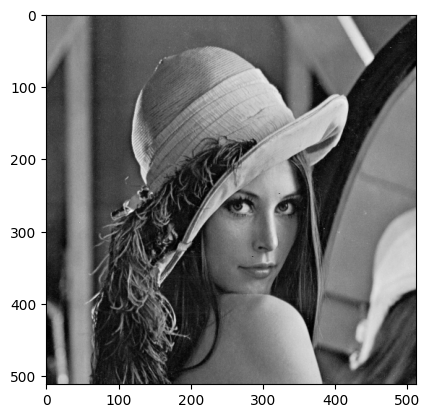

In [ ]:
img=io.imread('lena.tif')

plt.figure()
plt.imshow(img, cmap='gray')
plt.show()

### Defining Gaussien Function

In [ ]:
def Gaussien(ima, sigma):

  '''
    Returns the 2D Gaussien function centered in the middle of the image
  '''

  W = np.zeros(ima.shape)
  m = ima.shape[0] #lignes
  n = ima.shape[1] #col
  a1 = m/2 
  a2 = n/2

  for i in range(m):
    for j in range(n):
      num = - ((i - a1)**2 +(j - a2)**2)
      den = 2*sigma**2
      W[i,j] = np.exp(num/den)
   
  return W
    

### Getting the Gaussian Module

In [ ]:
#defining Gaussien standart deviation
sigma = 0.9
#Using our function 
Gauss = Gaussien(img, sigma)
#Normalizing (sum of all point equals 1)
W_abs = Gauss/(Gauss.sum()) 

Before use the numpy FFT-2D we need to shift the position of the gaussian center to the image origin (0,0).

In [ ]:
W_abs_shifted = ifftshift(W_abs)

### Obtaining the noise-power spectrum

We consider random phases to obtain a Gaussian phasor

In [ ]:
#creating a matrix of angles ranging between 0 and 1
ang_phase = np.random.rand(img.shape[0], img.shape[1]) 

#changing the range to 0 and 2*pi
ang_phase = (ang_phase/np.max(ang_phase))*2*np.pi

#creating a phasor with the random angles and module equals 1
phase = np.exp(1j*ang_phase)

#obtaining the noise power spectrum as a fourier transform of the gaussian function with random phases
W = fft2(W_abs_shifted) * phase 

### Grainy Image 

In [ ]:
#our grain is the real part of the noise power spectrum inverse fourier transform  
grain = np.real(ifft2(W))

#lbd (lambda) is a simply gain
lbd = 3*1e4

#our final image (with grains) is the sum of the real image 
#with the real part of the noise power spectrum inverse fourier transform  
img_out = (img + grain*lbd)

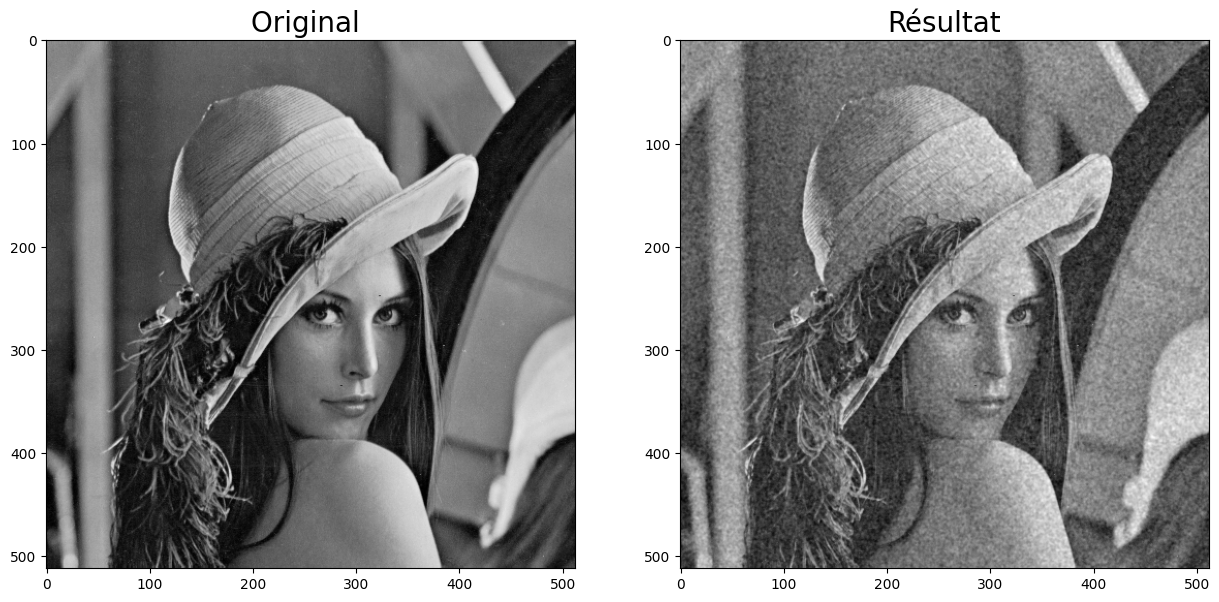

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))
axs[0].imshow(img, cmap="gray")  
axs[1].imshow(img_out, cmap="gray")
axs[0].set_title('Original ', fontdict = {'fontsize' : 20})
axs[1].set_title('Résultat', fontdict = {'fontsize' : 20});

fig.savefig('lena-grain.png', bbox_inches='tight')

## Second approach

(2, 2)

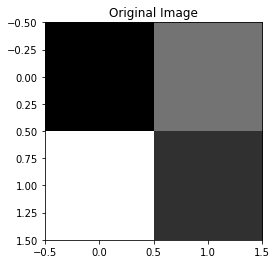

In [ ]:
# Creating an image
#im_orig = 64*np.ones((2,2))
#im_orig[1,1] = 255
#plt.imshow(im_orig, cmap='gray')
#plt.title('Original Image')
#im_orig.shape

# Creating an image
im_orig = 64*np.ones((2,2))

im_orig[0,1] = 150
im_orig[1,0] = 255
im_orig[1,1] = 100

plt.imshow(im_orig, cmap='gray')
plt.title('Original Image')
im_orig.shape

### DEFINING FUNCTIONS

#### grain centers

In [ ]:
def creat_grain_centers(im, r, e=0.01):
  '''
    Return a list of grains centers position in image
    The list dimention can be interpreted as: (pixel, grain in the pixel, grain_center_position (x,y))
  '''
  #image dimensions
  dimx = im.shape[0]
  dimy = im.shape[1]

  #list for save centers
  grain_center_list = []

  #initializing normalized image
  im_norm = np.zeros(im.shape)

  #initializing array of lambdas  
  lbd = np.zeros(im.shape)
  
  #for each image pixel
  for i in range(dimx):
    for j in range(dimy):

      #image normalization
      im_norm[i,j] = im[i,j]/(255 + e)

      #piecewise constant lambda of Poisson Distribution for 
      lbd[i,j] = 1/(np.pi*r**2) * np.log10(1/(1-im_norm[i,j])) 

      Q = np.random.poisson(lbd[i,j]) #Quantity of grain for each pixel 
      x = [] #initializing list of grain centers

      for _ in range(Q): 
        c_x = np.random.uniform(i, i+1) #random uniform distribution of position x 
        c_y = np.random.uniform(j, j+1) #random uniform distribution of position y
        x.append((c_x,c_y)) #adding a tuple of sorted grain center 
      grain_center_list.append(x) #adding the list of grains centers to the final list
  
  #transforming centers list into a matrix
  grain_center_array = grain_center_list[0] #x_grains get the origin pixel grains (0,0)
  qt_of_pixels = len(grain_center_list)  #quantity of pixel
  for p in range(1, qt_of_pixels): #for each pixel 
    if (grain_center_list[p]): #if there are grains in pixel
      grain_center_array = np.concatenate((grain_center_array, grain_center_list[p]), axis=0)
  
  return grain_center_array

#### grain image

In [ ]:
#grain_image 
def grain_image(img_size, grain_centers, r, zoom=1):
  '''
    return the grainy image
  '''

  new_sizex = zoom*img_size[0]
  new_sizey = zoom*img_size[1]

  grain_centers = grain_centers*zoom

  #inicializing grains img
  y = np.zeros((new_sizex,new_sizey)) 
  count = 0
  #for each pixel on image
  for i in range(new_sizex): 
    for j in range(new_sizey):
      for center in grain_centers:
        #if the pixel is in the circle then turn it white
        dist = (center - np.array((i+0.5,j+0.5)))**2
        dist = np.sum(dist)
        if dist < (r*zoom)**2:
          y[i,j] = 255
          break
      
      
  return y

### Grainy image

In [ ]:
#defining radius
r = 0.02 #r = 0.2
#obtaining centers 
grain_centers = creat_grain_centers(im_orig, r, e=0.1)

#results: a matrix with each grain center position joined along rows
grain_centers.shape

(3326, 2)

In [ ]:
#creating the grainy image
im_gran = grain_image(im_orig.shape, grain_centers, r, zoom=100)
plt.imshow(im_gran, cmap='gray')
im_gran.shape
plt.savefig("aiai.png", bbox_inches = "tight")

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))
axs[0].imshow(im_orig, cmap="gray")  
axs[1].imshow(im_gran, cmap="gray")
axs[0].set_title('Original ', fontdict = {'fontsize' : 20})
axs[1].set_title('Résultat', fontdict = {'fontsize' : 20});

fig.savefig('grainy.png', bbox_inches='tight')
plt.savefig("aiai4.png", bbox_inches = "tight")

In [ ]:
#creating the grainy image
im_gran1 = grain_image(im_orig.shape, grain_centers, r, zoom=20)
plt.imshow(im_gran, cmap='gray')
im_gran.shape
plt.savefig("aiaikqjjk.png", bbox_inches = "tight")

In [ ]:
#using gaussian filter (low pass filter) 
im_filtered = ndi.gaussian_filter(im_gran, sigma=1)
plt.imshow(im_filtered, cmap='gray')
plt.savefig("aiai1.png", bbox_inches = "tight")

In [ ]:
#showing a window
plt.imshow(im_filtered[75:125,75:125], cmap='gray')
plt.savefig("aiai3.png", bbox_inches = "tight")

In [ ]:
#doing a dezoom (sub-sampling) to obtain the final image
im_final = ndi.zoom(im_filtered, zoom=0.4, prefilter=False)

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))
axs[0].imshow(im_orig, cmap="gray")  
axs[1].imshow(im_final, cmap="gray")
axs[0].set_title('Original ', fontdict = {'fontsize' : 20})
axs[1].set_title('Résultat', fontdict = {'fontsize' : 20});

fig.savefig('grainy.png', bbox_inches='tight')
plt.savefig("aiai4.png", bbox_inches = "tight")